In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.graph_objects as go
from folium.plugins import HeatMap
import folium
from mlxtend.frequent_patterns import apriori, association_rules

data = pd.read_csv('./BikeSales_with_coordinates.csv')

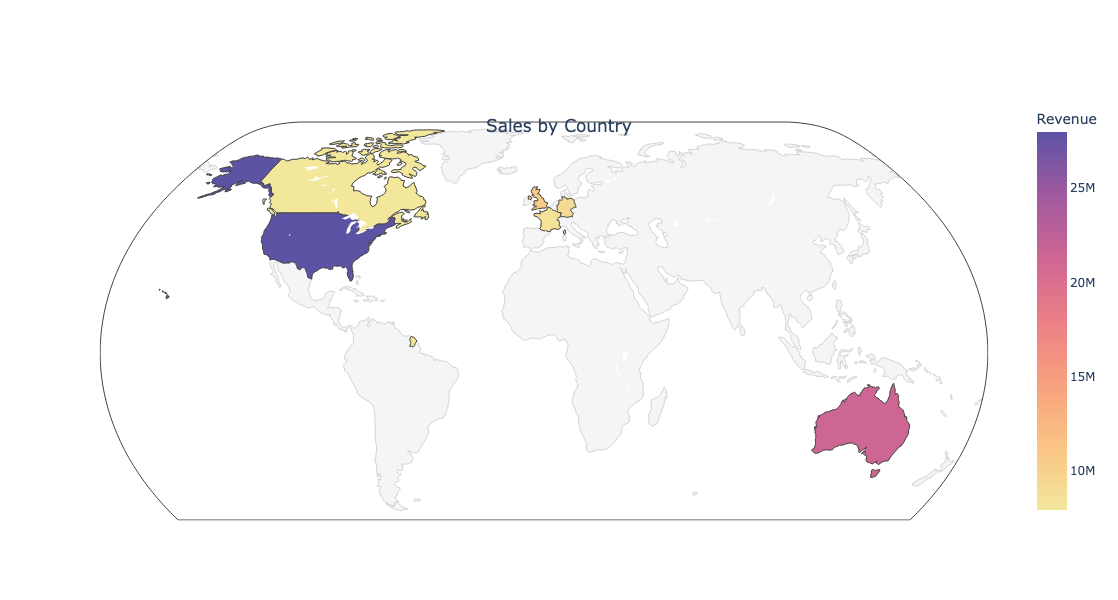

In [7]:
# Group by country and calculate total revenue
country_sales = data.groupby('Country')['Revenue'].sum().reset_index()

# Plot a map
fig = px.choropleth(
    country_sales, 
    locations="Country", 
    locationmode='country names',
    color="Revenue", 
    title="Sales by Country",
    color_continuous_scale=px.colors.sequential.Sunset # Color scale for the map
)

# Update layout to make the map larger and adjust the title position
fig.update_layout(
    width=1000,  # Set map width
    height=600,  # Set map height
    title={
        'text': "Sales by Country",  # Title text
        'y': 0.8,  # Vertical position (lowered)
        'x': 0.5,  # Horizontal position (centered)
        'xanchor': 'center',  # Horizontal alignment
        'yanchor': 'top'  # Vertical alignment
    }
)

# Update the geos layout to change the land color for areas without data and remove Antarctica
fig.update_geos(
    landcolor="#F5F5F7",  # Light gray for land without data
    bgcolor="#ffffff",     # Background color
    showcoastlines=True,   # Show coastlines
    coastlinecolor="LightGray",  # Coastline color
    projection_type="natural earth",  # Map projection type
    visible=True,
    lataxis_range=[-60, 90]  # Restrict latitude to remove Antarctica
)

fig.show()


In [5]:
# Prepare data for heatmap
heatmap_data = data[['Latitude', 'Longitude', 'Revenue']].dropna()

# Create Folium map
heatmap_map = folium.Map(location=[20, 0], zoom_start=2)
HeatMap(heatmap_data.values, radius=10).add_to(heatmap_map)
heatmap_map.save('heatmap.html')


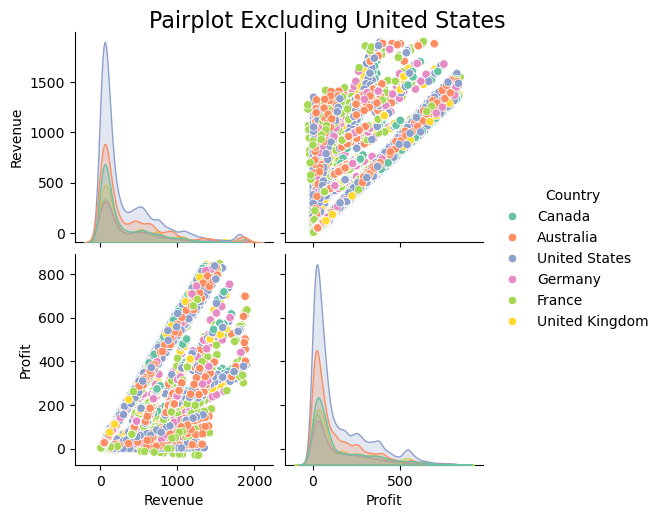

In [10]:
# Suppose we want to remove outliers in Revenue and Profit
columns_to_check = ['Revenue', 'Profit']

# Calculate IQR
Q1 = data[columns_to_check].quantile(0.25)  # First quartile
Q3 = data[columns_to_check].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range

# Define the range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data_no_outliers = data[~((data[columns_to_check] < lower_bound) | (data[columns_to_check] > upper_bound)).any(axis=1)]

# Select variables for analysis
pairplot_data = data_no_outliers[['Revenue', 'Profit', 'Country']]

# Plot a pairplot, differentiated by country
sns.pairplot(pairplot_data, hue='Country', diag_kind='kde', palette='Set2')

plt.suptitle('Pairplot Excluding United States', y=1.02, fontsize=16)
plt.show()

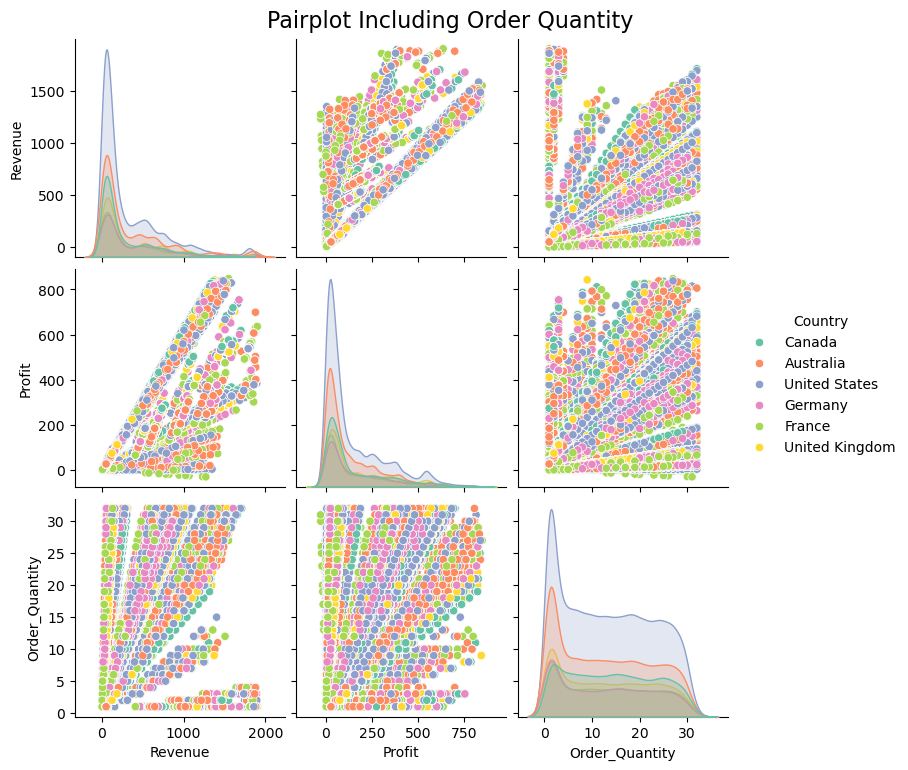

In [12]:
# remove outliers in Revenue and Profit
columns_to_check = ['Revenue', 'Profit']

# Calculate IQR
Q1 = data[columns_to_check].quantile(0.25)  # First quartile
Q3 = data[columns_to_check].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range

# Define the range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
data_no_outliers = data[~((data[columns_to_check] < lower_bound) | (data[columns_to_check] > upper_bound)).any(axis=1)]

# Select variables for analysis
pairplot_data = data_no_outliers[['Revenue', 'Profit', 'Order_Quantity', 'Country']]

# Plot a pairplot: differentiated by country
sns.pairplot(pairplot_data, hue='Country', diag_kind='kde', palette='Set2')

plt.suptitle('Pairplot Including Order Quantity', y=1.02, fontsize=16)
plt.show()

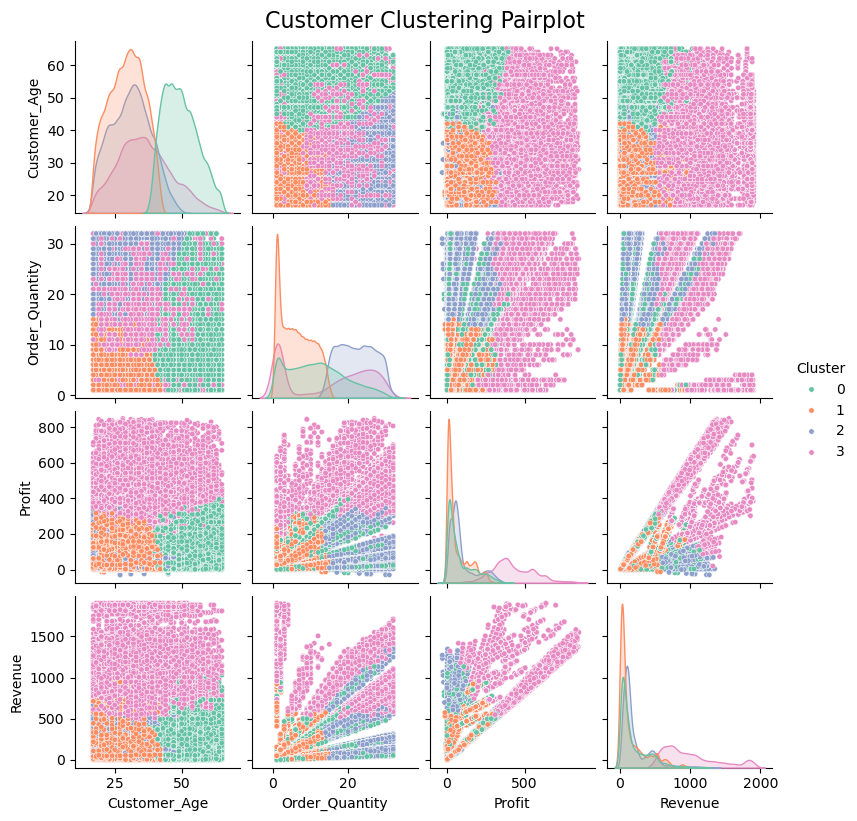

In [86]:
# Step 1: Select features for clustering
features = ['Customer_Age', 'Order_Quantity', 'Profit', 'Revenue']

# Step 2: Remove outliers using IQR
Q1 = data[features].quantile(0.25)  # First quartile
Q3 = data[features].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Keep only rows within the IQR range for all features
data_no_outliers = data[
    ~((data[features] < lower_bound) | (data[features] > upper_bound)).any(axis=1)
].copy()

# Step 3: Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_no_outliers[features])

# Step 4: Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
data_no_outliers['Cluster'] = kmeans.fit_predict(scaled_features)

# Step 5: Visualize clustering results using Pairplot
sns.pairplot(data_no_outliers, 
             vars=features, 
             hue='Cluster', 
             palette='Set2', 
             height=2.0, 
             plot_kws={'s': 15})
plt.suptitle('Customer Clustering Pairplot', y=1.02, fontsize=16)
plt.show()

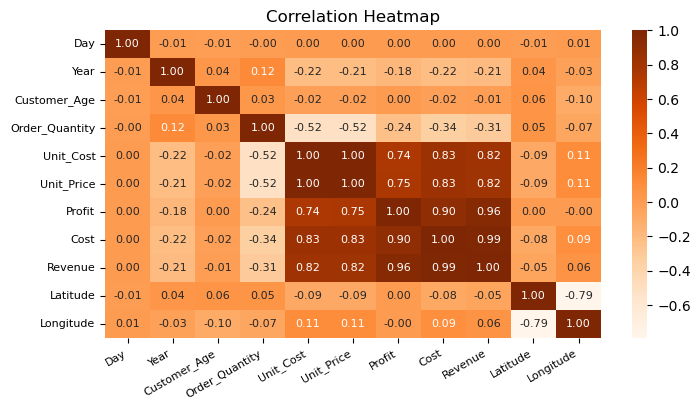

In [16]:
# Select only numeric columns
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
corr = numeric_data.corr()

# Create the heatmap with adjusted fonts and rotation
plt.figure(figsize=(8, 4))  # Adjust the figure size
heatmap = sns.heatmap(corr, cmap='Oranges', annot=True, fmt=".2f", cbar=True, annot_kws={"size": 8})

# Customize the font size for x and y axis
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=30, ha='right', fontsize=8)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=8)

# Add a title to the heatmap
plt.title("Correlation Heatmap", fontsize=12)
plt.show()

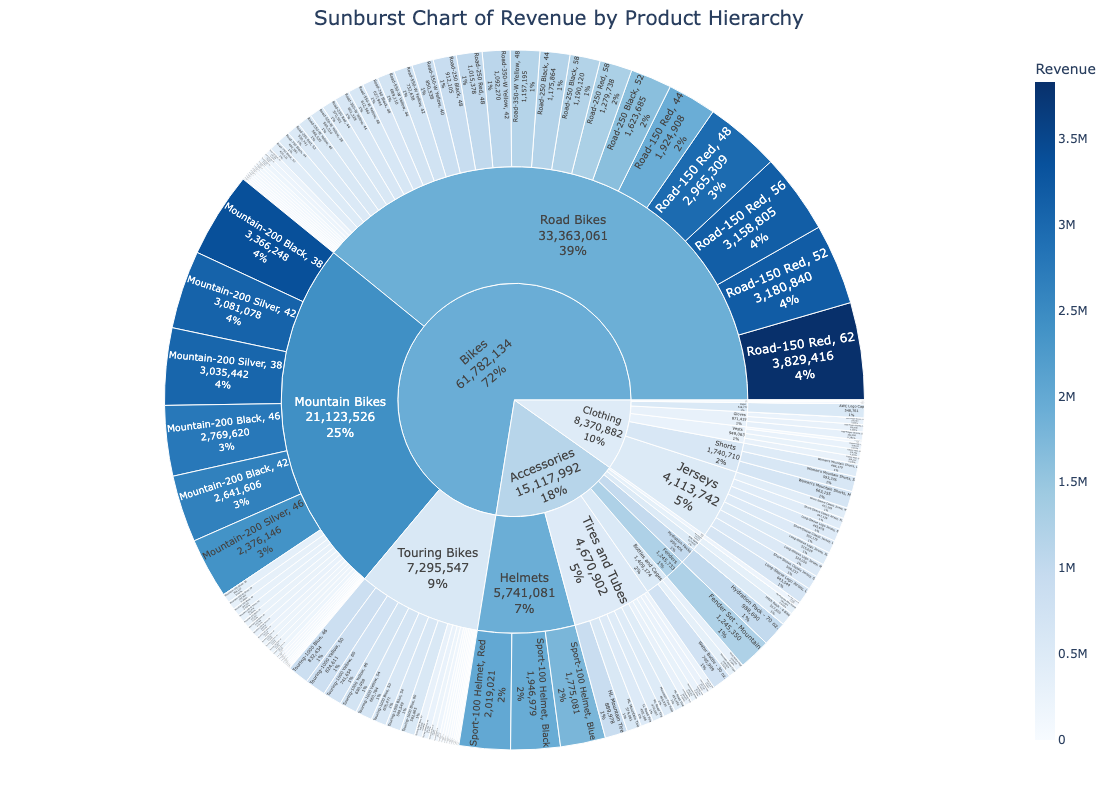

In [18]:
# Aggregate data for the sunburst
# Replace 'Product_Category', 'Sub_Category', and 'Revenue' with relevant columns
sunburst_data = data.groupby(['Product_Category', 'Sub_Category', 'Product'])['Revenue'].sum().reset_index()

# Create a sunburst chart
fig = px.sunburst(
    sunburst_data,
    path=['Product_Category', 'Sub_Category', 'Product'],  # Define hierarchy
    values='Revenue',  # Values for size
    color='Revenue',  # Values for color
    color_continuous_scale='Blues',  # Color scale
    title="Sunburst Chart of Revenue by Product Hierarchy",
)

# Update layout for better readability
fig.update_layout(
    margin=dict(t=50, l=50, r=50, b=50),  # Increase margins
    width=1000,  # Set chart width
    height=800,  # Set chart height
    title_font_size=20,  # Increase title font size
    title_x=0.5,  # Center the title horizontally
    coloraxis_colorbar=dict(  # Adjust the color bar settings
        title="Revenue",  # Title for the color bar
        ticktext=["Low", "High"],  # Set tick text for the color bar
        lenmode="pixels",  # Set length mode for the color bar
        thickness=20,  # Set thickness of the color bar
        x=1.05,  # Position the color bar slightly outside the chart
        y=0.5,  # Center the color bar vertically        
    )
)

# Update trace text for larger font
fig.update_traces(
    textinfo="label+value+percent entry",  # Show label, value, and percentage
    textfont_size=12,  # Increase font size for labels
)

# Show the chart
fig.show()

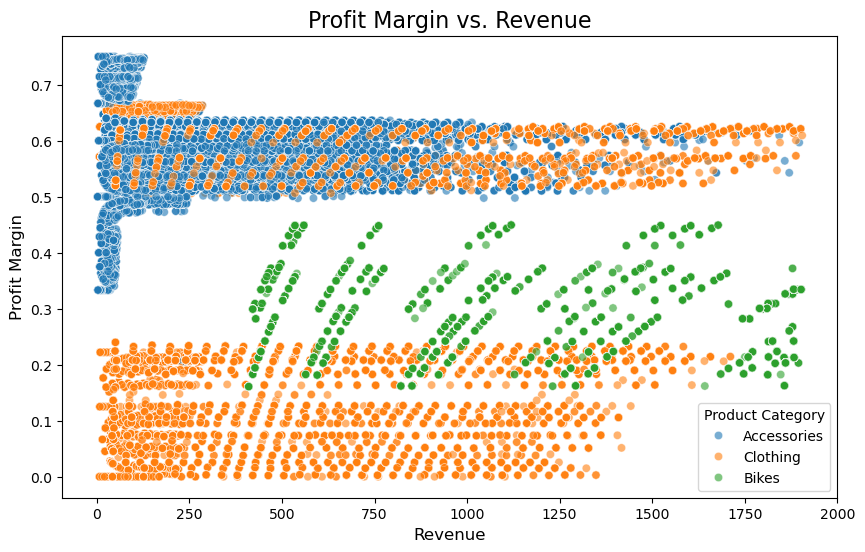

In [60]:
# Step 1: Define columns to check for outliers
columns_to_check = ['Revenue', 'Profit_Margin']

# Step 2: Calculate IQR for each column
Q1 = data[columns_to_check].quantile(0.25)  # First quartile
Q3 = data[columns_to_check].quantile(0.75)  # Third quartile
IQR = Q3 - Q1  # Interquartile Range

# Step 3: Define bounds to filter out outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 4: Remove rows with outliers
data_no_outliers = data[~((data[columns_to_check] < lower_bound) | (data[columns_to_check] > upper_bound)).any(axis=1)]

# Step 5: Scatter plot without outliers
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data_no_outliers, x='Revenue', y='Profit_Margin', hue='Product_Category', alpha=0.6)
plt.title('Profit Margin vs. Revenue', fontsize=16)
plt.xlabel('Revenue', fontsize=12)
plt.ylabel('Profit Margin', fontsize=12)
plt.legend(title='Product Category')
plt.show()
